In [3]:
import copy
import pandas
from sklearn.metrics import accuracy_score
from dl85 import DL85Classifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import utils
import relabeling_fairlearn
from tqdm import tqdm
import math
from sklearn.tree import DecisionTreeClassifier
import ast

In [4]:


df = pandas.read_csv("../dataset_perso/Lawsuit.csv")
FILE_NAME = "lawsuit_k_supp2_relab_sklearn"

del df['ID']
salary_mean = np.mean(np.array(df["Sal94"].tolist(), float))
for i in range(0,len(df)):
    if df.at[i, "Sal94"] >= salary_mean:
        df.at[i, "Salary_mean"] = 1
    else:
        df.at[i, "Salary_mean"] = 0
del df["Sal94"]
del df["Sal95"]
col = ['Rank', 'Dept']
df = df.drop(['Prate', 'Exper'], axis=1)
df = pd.get_dummies(df, columns=col)

for i in range(0,len(df)):
    if df.at[i, "Gender"] == 1:
        df.at[i, "Gender"] = 0
    else:
        df.at[i, "Gender"] = 1


X = df.loc[:, ~df.columns.isin(['Gender', 'Salary_mean'])]
y = df['Salary_mean']
sensitive = df['Gender']
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

In [5]:
pd.set_option('max_columns', None)


In [6]:
def leafs_discimination(clf, x, y, sensitive, n_zero, n_one, discriminations, length, node_id, path=tuple()):
    feature = clf.tree_.feature[node_id]

    if feature >= 0:
        tmp = path + ((node_id, feature, 'left'),)
        leafs_discimination(clf, x, y, sensitive, n_zero, n_one, discriminations, length, clf.tree_.children_left[node_id], tmp)
        tmp = path + ((node_id, feature, 'right'),)
        leafs_discimination(clf, x, y, sensitive, n_zero, n_one, discriminations, length, clf.tree_.children_right[node_id], tmp)
    else:
        transactions = relabeling_fairlearn.get_transactions_by_leaf(clf, path, x)
        discriminations[node_id] = utils.discr_add(transactions, y, sensitive)

def sum_discri(clf, X, y, sensitive, do_abs = False):
    cnt = np.unique(sensitive, return_counts=True)[1]

    discrimination = [None] * len(clf.tree_.value)
    leafs_discimination(clf, X, y, sensitive, cnt[0], cnt[1], discrimination, len(y), 0)

    s=0
    for d in discrimination:
        if d:
            if do_abs:
                s += abs(d)
            else:
                s += d
    return s

In [7]:
result = pd.DataFrame(columns=["k", "depth", "random_state", "accuracy_pred", "accuracy_test",  "discrimination_train", "discrimination_train_pred", "discrimination_test", "sum_discrimination_additive_train", "sum_discrimination_additive_train_pred", "sum_discrimination_additive_test_pred", "sum_discrimination_additive_train_abs", "sum_discrimination_additive_train_pred_abs", "sum_discrimination_additive_test_pred_abs", "min_supp", "clf.tree_"])

for leaf_limit in range (1, 4):
    result['accuracy_relab_'+str(leaf_limit)] = np.nan
    result['discrimination_relab_'+str(leaf_limit)] = np.nan
    result['discrimination_relab_abs_'+str(leaf_limit)] = np.nan
    result['accuracy_relab_test_'+str(leaf_limit)] = np.nan
    result['discrimination_relab_test_'+str(leaf_limit)] = np.nan
    result['discrimination_relab_test_abs_'+str(leaf_limit)] = np.nan

for threshold in [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
    result['accuracy_relab_'+str(threshold)] = np.nan
    result['discrimination_relab_'+str(threshold)] = np.nan
    result['discrimination_relab_abs_'+str(threshold)] = np.nan
    result['accuracy_relab_test_'+str(threshold)] = np.nan
    result['discrimination_relab_test_'+str(threshold)] = np.nan
    result['discrimination_relab_test_abs_'+str(threshold)] = np.nan

dl = DL85Classifier()
dl.fit(X_train, list(y_train))

def round_down(a, exp=11):
    dec = 10**exp
    return round(a * dec)/float(dec)

cnt_error = 0
total_iter = 0
if True:
    min_supp = 2
    for random_state in tqdm(range(1, 101, 2)):
    #or random_state in range(1, 10, 2):
        if random_state in [17, 35, 43, 71, 91]:
            continue
        X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(random_state, X, y, sensitive)

        for depth in [1, 2, 3, 4, 5, 6, 7]:
            index = len(result.index)
            clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
            clf.fit(X_train, list(y_train))

            y_pred_train = clf.predict(X_train)
            y_pred_test = clf.predict(X_test)

            accuracy_train = round_down(accuracy_score(y_train, y_pred_train))
            accuracy_test = round_down(accuracy_score(y_test, y_pred_test))

            discrimination_train = round_down(utils.discrimination(y_train, sensitive_train))
            discrimination_train_pred = round_down(utils.discrimination(y_pred_train, sensitive_train))
            discrimination_test = round_down(utils.discrimination(y_pred_test, sensitive_test))

            sum_discrimination_additive_train = sum_discri(clf, X_train, y_train, sensitive_train, False)
            sum_discrimination_additive_train_abs = sum_discri(clf, X_train, y_train, sensitive_train, True)

            sum_discrimination_additive_train_pred = sum_discri(clf, X_train, y_pred_train, sensitive_train, False)
            sum_discrimination_additive_train_pred_abs = sum_discri(clf, X_train, y_pred_train, sensitive_train, True)

            sum_discrimination_additive_test_pred = sum_discri(clf, X_test, y_pred_test, sensitive_test, False)
            sum_discrimination_additive_test_pred_abs = sum_discri(clf, X_test, y_pred_test, sensitive_test, True)

            result.at[index, 'k'] = 0
            result.at[index, 'depth'] = depth
            result.at[index, 'random_state'] = random_state
            result.at[index, 'accuracy_pred'] = accuracy_train
            result.at[index, 'accuracy_test'] = accuracy_test
            result.at[index, 'discrimination_train'] = discrimination_train
            result.at[index, 'discrimination_train_pred'] = discrimination_train_pred
            result.at[index, 'discrimination_test'] = discrimination_test
            result.at[index, 'sum_discrimination_additive_train'] = sum_discrimination_additive_train
            result.at[index, 'sum_discrimination_additive_train_pred'] = sum_discrimination_additive_train_pred
            result.at[index, 'sum_discrimination_additive_test_pred'] = sum_discrimination_additive_test_pred
            result.at[index, 'sum_discrimination_additive_train_abs'] = sum_discrimination_additive_train_abs
            result.at[index, 'sum_discrimination_additive_train_pred_abs'] = sum_discrimination_additive_train_pred_abs
            result.at[index, 'sum_discrimination_additive_test_pred_abs'] = sum_discrimination_additive_test_pred_abs
            result.at[index, 'min_supp'] = min_supp
            result.at[index, 'clf.tree_'] = clf.tree_

            clf_original = copy.deepcopy(clf)

            # RELAB
            for leaf_limit in range (1, 4):
                clf = copy.deepcopy(clf_original)
                leafs = list()

                leafs_relab = relabeling_fairlearn.relab_leaf_limit(clf, X_train, y_train, y_pred_train, sensitive_train, leaf_limit)

                for leaf in leafs_relab:
                    relabeling_fairlearn.browse_and_relab(clf, leaf.node_id)

                # NEW PREDICT
                y_pred_train_relab = clf.predict(X_train)
                y_pred_test_relab = clf.predict(X_test)
                result.at[index, 'accuracy_relab_'+str(leaf_limit)] = round_down(accuracy_score(y_train, y_pred_train_relab), 4)
                result.at[index, 'discrimination_relab_'+str(leaf_limit)] = round_down(relabeling_fairlearn.discrimination(y_train, y_pred_train_relab, sensitive_train))
                result.at[index, 'discrimination_relab_abs_'+str(leaf_limit)] = sum_discri(clf, X_train, y_pred_train_relab, sensitive_train, True)
                result.at[index, 'accuracy_relab_test_'+str(leaf_limit)] = round_down(accuracy_score(y_test, y_pred_test_relab), 4)
                result.at[index, 'discrimination_relab_test_'+str(leaf_limit)] = round_down(relabeling_fairlearn.discrimination(y_test, y_pred_test_relab, sensitive_test))
                result.at[index, 'discrimination_relab_test_abs_'+str(leaf_limit)] = sum_discri(clf, X_test, y_pred_test_relab, sensitive_test, True)

            for threshold in [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
                clf = copy.deepcopy(clf_original)
                leafs = list()
                leafs_relab = relabeling_fairlearn.leaves_to_relabel(clf, X_train, y_train, y_pred_train, sensitive_train, threshold)
                for leaf in leafs_relab:
                    relabeling_fairlearn.browse_and_relab(clf, leaf.node_id)

                # NEW PREDICT
                y_pred_train_relab = clf.predict(X_train)
                y_pred_test_relab = clf.predict(X_test)
                result.at[index, 'accuracy_relab_'+str(threshold)] = round_down(accuracy_score(y_train, y_pred_train_relab), 4)
                result.at[index, 'discrimination_relab_'+str(threshold)] = round_down(relabeling_fairlearn.discrimination(y_train, y_pred_train_relab, sensitive_train))
                result.at[index, 'discrimination_relab_abs_'+str(threshold)] = sum_discri(clf, X_train, y_pred_train_relab, sensitive_train, True)
                result.at[index, 'accuracy_relab_test_'+str(threshold)] = round_down(accuracy_score(y_test, y_pred_test_relab), 4)
                result.at[index, 'discrimination_relab_test_'+str(threshold)] = round_down(relabeling_fairlearn.discrimination(y_test, y_pred_test_relab, sensitive_test))
                result.at[index, 'discrimination_relab_test_abs_'+str(threshold)] = sum_discri(clf, X_test, y_pred_test_relab, sensitive_test, True)


                sum_acc = 0
                sum_disc = 0

                for leaf in leafs_relab:
                    sum_acc += leaf.acc
                    sum_disc += leaf.disc
                new_acc= round_down(accuracy_train+sum_acc)
                new_disc = round_down(discrimination_train_pred+sum_disc)
                accuracy_train_relab = round_down(accuracy_score(y_train, y_pred_train_relab))
                discrimation_train_pred_relab = round_down(utils.discrimination(y_pred_train_relab, sensitive_train))
                sum_acc = round_down(sum_acc)
                sum_disc = round_down(sum_disc)

                if not (relabeling_fairlearn.discrimination(y_train, y_pred_train_relab, sensitive_train) <= threshold
                    and max(new_acc, accuracy_train_relab) - min(new_acc, accuracy_train_relab) < 1/(10**10)
                    and max(new_disc, discrimation_train_pred_relab) - min(new_disc, discrimation_train_pred_relab) < 1/(10**10)):
                    print(result.iloc[index])
                    print(f"thresh: {str(threshold)}")
                    print(f"{relabeling_fairlearn.discrimination(y_train, y_pred_train_relab, sensitive_train)} <= {threshold}")
                    print()
                    leafs_relab = list(leafs_relab)
                    leafs_relab = sorted(leafs_relab, key=lambda x: x.node_id)
                    for leaf in leafs_relab:
                        print(leaf)
                        print()

                    print(f"Accuracy:\n"
                          f"    Before      : {accuracy_train}\n"
                          f"    Leafs       : {sum_acc}\n"
                          f"    After       : {accuracy_train_relab}\n"
                          f"    Expected    : {new_acc}\n"
                          f"    Check       : {new_acc == accuracy_train_relab}")
                    print(f"Discrim:\n"
                          f"    Before      : {discrimination_train_pred}\n"
                          f"    Leafs       : {sum_disc }\n"
                          f"    After       : {discrimation_train_pred_relab}\n"
                          f"    Expected    : {new_disc}\n"
                          f"    Check       : {new_disc== discrimation_train_pred_relab}")
                    assert(relabeling_fairlearn.discrimination(y_train, y_pred_train_relab, sensitive_train) <= threshold)
                    assert(max(new_acc, accuracy_train_relab) - min(new_acc, accuracy_train_relab) < 1/(10**10))
                    assert(max(new_disc, discrimation_train_pred_relab) - min(new_disc, discrimation_train_pred_relab) < 1/(10**10))

    result.to_csv('save/'+FILE_NAME+'.csv', index=False)


100%|██████████| 50/50 [03:44<00:00,  4.48s/it]


In [8]:
df = pd.read_csv('save/'+FILE_NAME+".csv")
df = df.sort_values(['depth', 'random_state'])
df

,k,depth,random_state,accuracy_pred,accuracy_test,discrimination_train,discrimination_train_pred,discrimination_test,sum_discrimination_additive_train,sum_discrimination_additive_train_pred,sum_discrimination_additive_test_pred,sum_discrimination_additive_train_abs,sum_discrimination_additive_train_pred_abs,sum_discrimination_additive_test_pred_abs,min_supp,clf.tree_,accuracy_relab_1,discrimination_relab_1,discrimination_relab_abs_1,accuracy_relab_test_1,discrimination_relab_test_1,discrimination_relab_test_abs_1,accuracy_relab_2,discrimination_relab_2,discrimination_relab_abs_2,accuracy_relab_test_2,discrimination_relab_test_2,discrimination_relab_test_abs_2,accuracy_relab_3,discrimination_relab_3,discrimination_relab_abs_3,accuracy_relab_test_3,discrimination_relab_test_3,discrimination_relab_test_abs_3,accuracy_relab_0.0,discrimination_relab_0.0,discrimination_relab_abs_0.0,accuracy_relab_test_0.0,discrimination_relab_test_0.0,discrimination_relab_test_abs_0.0,accuracy_relab_0.05,discrimination_relab_0.05,discrimination_relab_abs_0.05,accuracy_relab_test_0.05,discrimination_relab_test_0.05,discrimination_relab_test_abs_0.05,accuracy_relab_0.1,discrimination_relab_0.1,discrimination_relab_abs_0.1,accuracy_relab_test_0.1,discrimination_relab_test_0.1,discrimination_relab_test_abs_0.1,accuracy_relab_0.15,discrimination_relab_0.15,discrimination_relab_abs_0.15,accuracy_relab_test_0.15,discrimination_relab_test_0.15,discrimination_relab_test_abs_0.15,accuracy_relab_0.2,discrimination_relab_0.2,discrimination_relab_abs_0.2,accuracy_relab_test_0.2,discrimination_relab_test_0.2,discrimination_relab_test_abs_0.2,accuracy_relab_0.25,discrimination_relab_0.25,discrimination_relab_abs_0.25,accuracy_relab_test_0.25,discrimination_relab_test_0.25,discrimination_relab_test_abs_0.25,accuracy_relab_0.3,discrimination_relab_0.3,discrimination_relab_abs_0.3,accuracy_relab_test_0.3,discrimination_relab_test_0.3,discrimination_relab_test_abs_0.3
0,0,1,1,0.755981,0.730769,0.325619,0.156476,0.266667,0.325619,0.156476,0.266667,0.325619,0.156476,0.266667,2,<sklearn.tree._tree.Tree object at 0x7fc8e2b2c...,0.6029,0.000000,0.000000,0.5769,0.000000,0.000000,0.2440,-0.156476,0.156476,0.2692,-0.266667,0.266667,0.2440,-0.156476,0.156476,0.2692,-0.266667,0.266667,0.6029,0.000000,0.000000,0.5769,0.000000,0.000000,0.6029,0.000000,0.000000,0.5769,0.000000,0.000000,0.6029,0.000000,0.000000,0.5769,0.000000,0.000000,0.6029,0.000000,0.000000,0.5769,0.000000,0.000000,0.7560,0.156476,0.156476,0.7308,0.266667,0.266667,0.7560,0.156476,0.156476,0.7308,0.266667,0.266667,0.7560,0.156476,0.156476,0.7308,0.266667,0.266667
7,0,1,3,0.770335,0.673077,0.304364,0.234535,-0.046083,0.304364,0.234535,-0.046083,0.304364,0.234535,0.046083,2,<sklearn.tree._tree.Tree object at 0x7fc8e2b2c...,0.6077,0.000000,0.000000,0.5577,0.000000,0.000000,0.2297,-0.234535,0.234535,0.3269,0.046083,0.046083,0.2297,-0.234535,0.234535,0.3269,0.046083,0.046083,0.6077,0.000000,0.000000,0.5577,0.000000,0.000000,0.6077,0.000000,0.000000,0.5577,0.000000,0.000000,0.6077,0.000000,0.000000,0.5577,0.000000,0.000000,0.6077,0.000000,0.000000,0.5577,0.000000,0.000000,0.6077,0.000000,0.000000,0.5577,0.000000,0.000000,0.7703,0.234535,0.234535,0.6731,-0.046083,0.046083,0.7703,0.234535,0.234535,0.6731,-0.046083,0.046083
14,0,1,5,0.765550,0.692308,0.324563,0.179566,0.172619,0.324563,0.179566,0.172619,0.324563,0.179566,0.172619,2,<sklearn.tree._tree.Tree object at 0x7fc8e1f32...,0.6077,0.000000,0.000000,0.5577,0.000000,0.000000,0.2344,-0.179566,0.179566,0.3077,-0.172619,0.172619,0.2344,-0.179566,0.179566,0.3077,-0.172619,0.172619,0.6077,0.000000,0.000000,0.5577,0.000000,0.000000,0.6077,0.000000,0.000000,0.5577,0.000000,0.000000,0.6077,0.000000,0.000000,0.5577,0.000000,0.000000,0.6077,0.000000,0.000000,0.5577,0.000000,0.000000,0.7656,0.179566,0.179566,0.6923,0.172619,0.172619,0.7656,0.179566,0.179566,0.6923,0.172619,0.172619,0.7656,0.179566,0.179566,0.6923,0.172619,0.172619
21,0,1,7,0.755981,0.730769,0.290782,0.185791,0

In [9]:
_COLORS4 = ['#ff0000', '#00ff00', '#0000ff', '#87cefa']
_COLORS5 = ['#008080', '#ffa500', '#00ff00', '#0000ff', '#ff1493']
_COLORS7 = ['#2e8b57', '#ff0000', '#ffd700', '#c71585', '#00ff00', '#0000ff', '#1e90ff']
_COLORS10 = ['#006400', '#00008b', '#b03060', '#ff4500', '#ffd700', '#7cfc00', '#00ffff', '#ff00ff', '#6495ed',
          '#ffdab9']
_COLORS11 = ['#8b4513', '#006400', '#4682b4', '#4b0082', '#ff0000', '#00ff7f', '#00ffff', '#0000ff', '#ffff54',
             '#ff1493', '#ffe4c4']

# Train

## Train: Accuracy/Discimination (leaf)

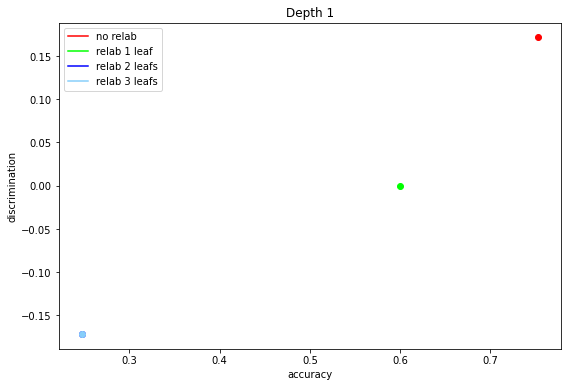

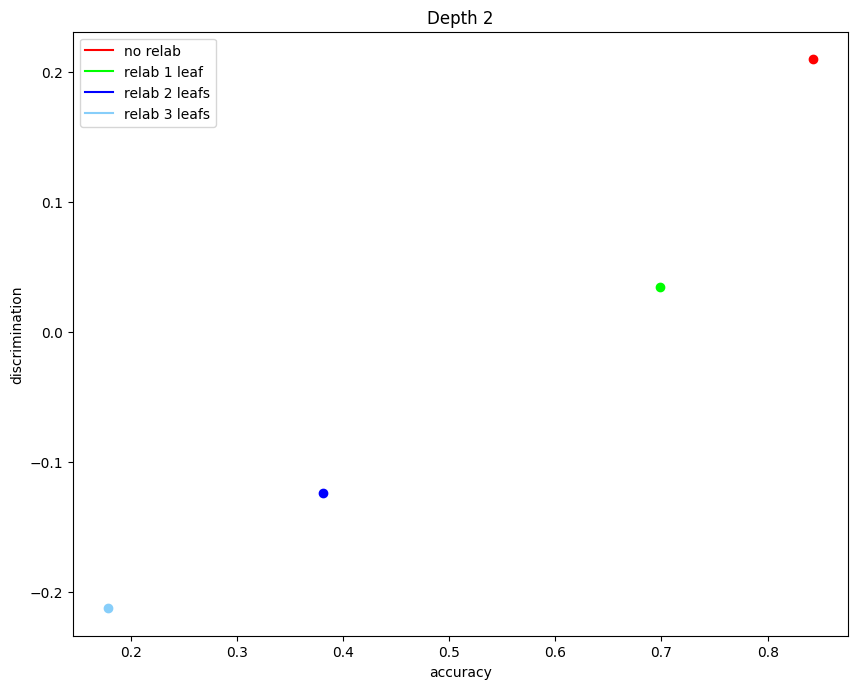

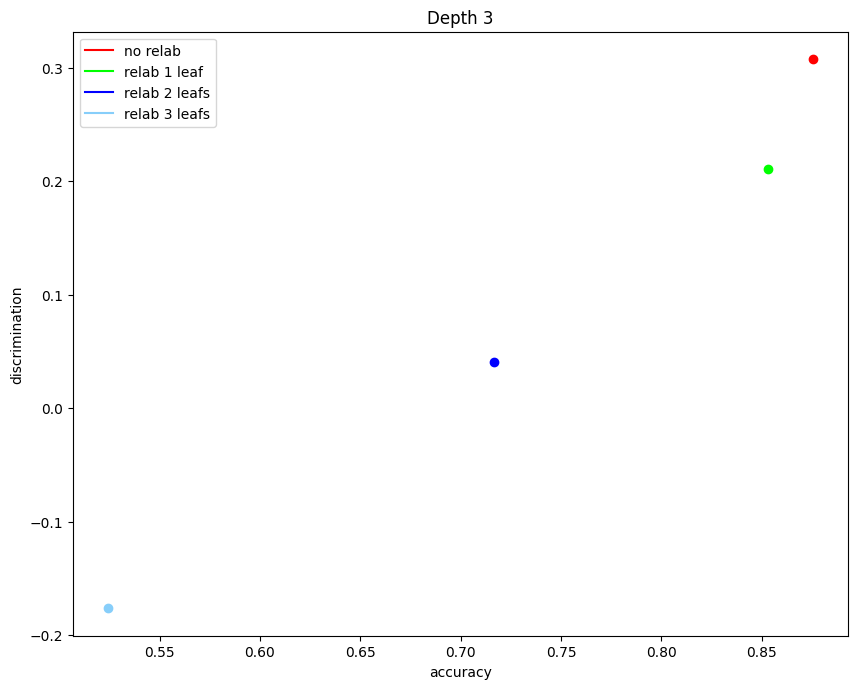

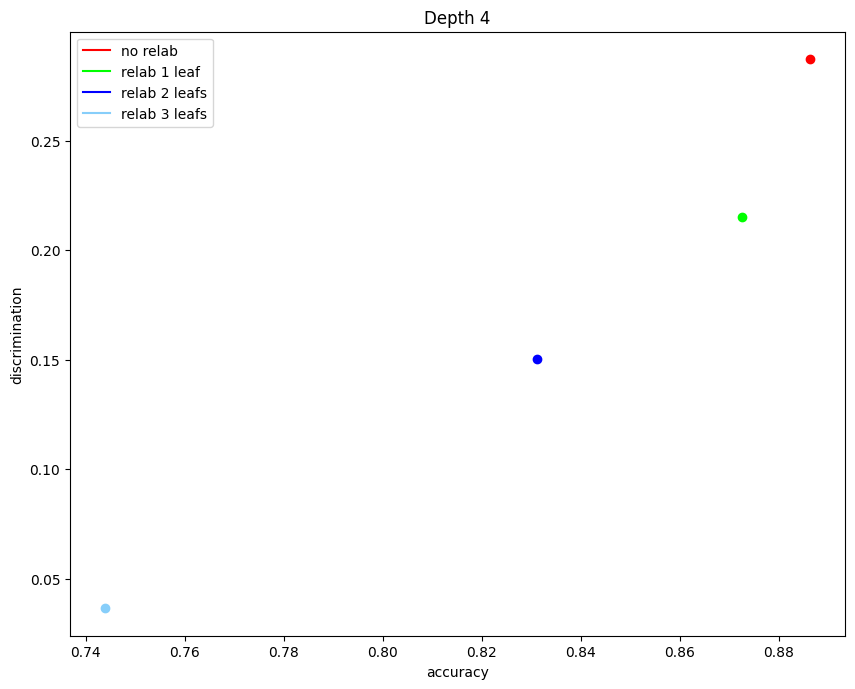

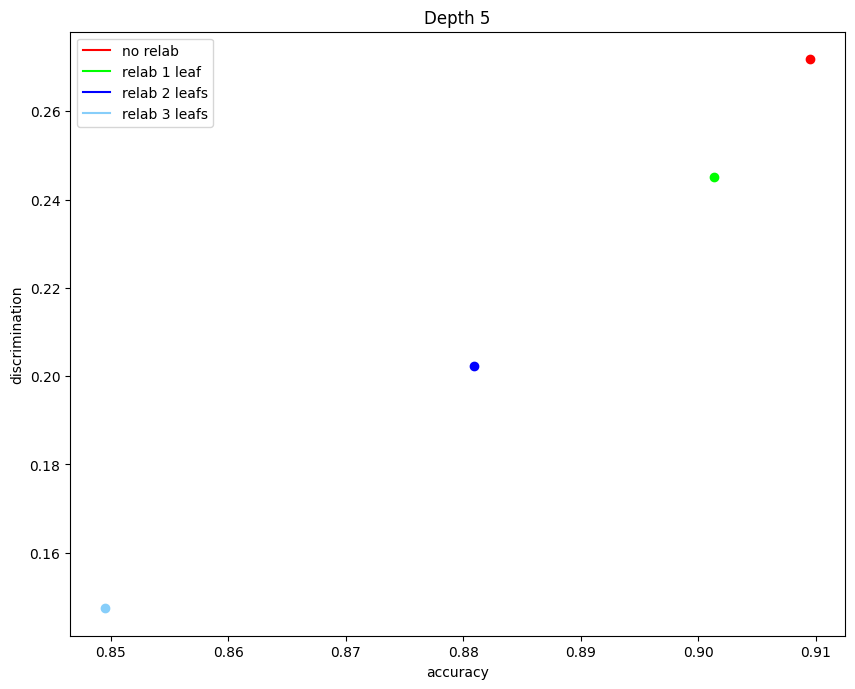

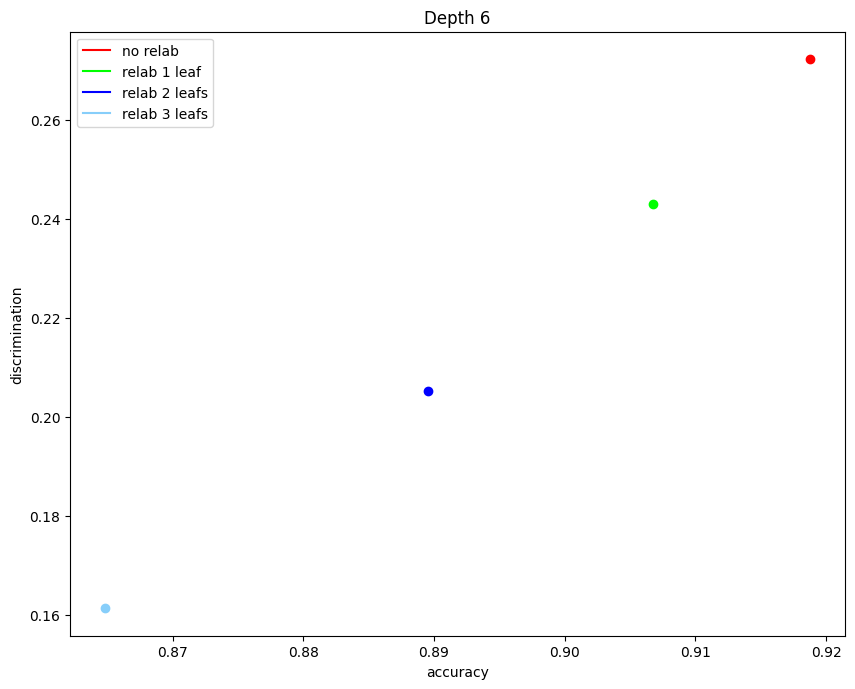

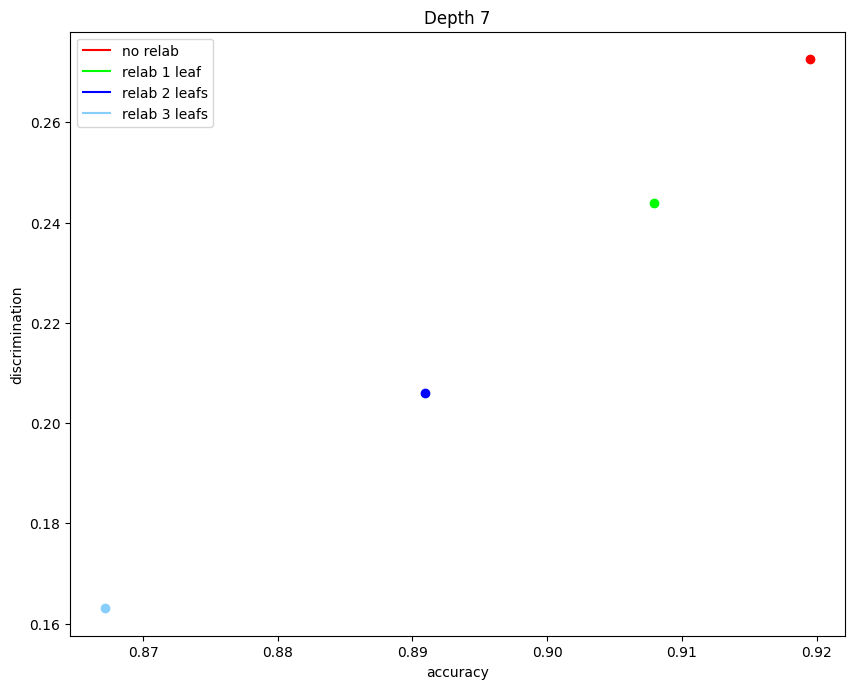

In [10]:
legends = ['no relab', 'relab 1 leaf', 'relab 2 leafs', 'relab 3 leafs']
fig, axes = plt.subplots()
colors11 = _COLORS11.copy()
colors4 = _COLORS4.copy()
for depth in df['depth'].unique():
    index_legends = 0
    for x_axe, y_axe in [('accuracy_pred', 'discrimination_train_pred'), ('accuracy_relab_1', 'discrimination_relab_1'), ('accuracy_relab_2', 'discrimination_relab_2'), ('accuracy_relab_3', 'discrimination_relab_3')]:
        index_color = 0
        y_values = list()
        x_values = list()
        for k in df['k'].unique():
            tmp = df.loc[(df["k"] == k) & (df["depth"] == depth)]
            x_values.append(tmp[x_axe].mean())
            y_values.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors4[index_legends])

            index_color +=1

        plt.plot(x_values, y_values, label=legends[index_legends], c=colors4[index_legends])
        index_legends +=1
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('discrimination')
    plt.xlabel('accuracy')
    #plt.ylim(-0.2, 0.3)
    #plt.xlim(0, 1)
    plt.legend()

    plt.show()

## Train: Accuracy/Discimination (threshold)

IndexError: list index out of range

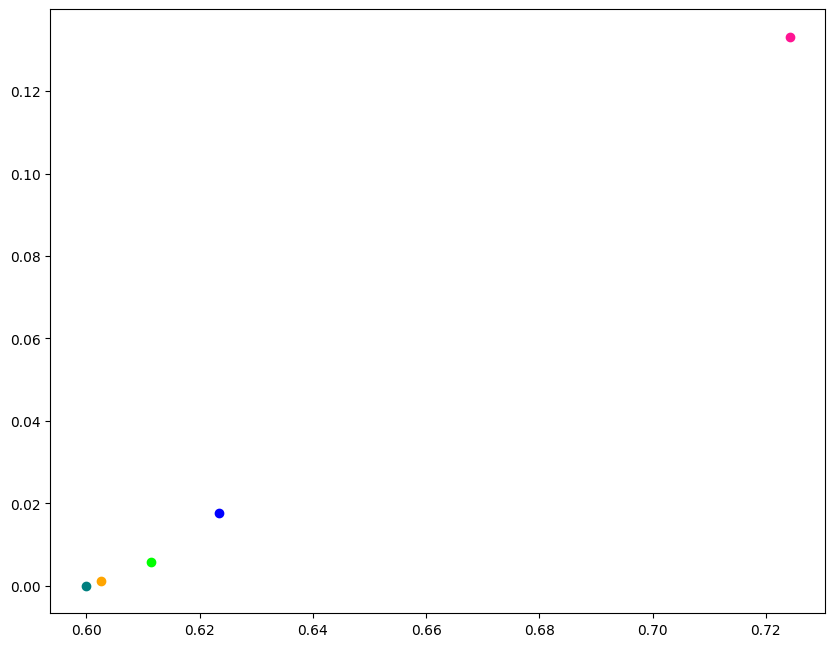

In [11]:
colors11 = _COLORS11.copy()
colors4 = _COLORS5.copy()
legends = ['relab discrim < 0', 'relab discrim < 0.1', 'relab discrim < 0.2', 'relab discrim < 0.3', 'no relab']
fig, axes = plt.subplots()
for depth in df['depth'].unique():
    index_legends = 0
    for x_axe, y_axe in [('accuracy_relab_0.0', 'discrimination_relab_0.0'), ('accuracy_relab_0.05', 'discrimination_relab_0.05'), 
                         ('accuracy_relab_0.1', 'discrimination_relab_0.1'), ('accuracy_relab_0.15', 'discrimination_relab_0.15'), 
                         ('accuracy_relab_0.2', 'discrimination_relab_0.2'), ('accuracy_relab_0.25', 'discrimination_relab_0.25'), 
                         ('accuracy_relab_0.3', 'discrimination_relab_0.3'), 
                         ('accuracy_pred', 'discrimination_train_pred')]:
        index_color = 0
        y_values = list()
        x_values = list()
        for k in df['k'].unique():
            tmp = df.loc[(df["k"] == k) & (df["depth"] == depth)]
            x_values.append(tmp[x_axe].mean())
            y_values.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors4[index_legends])

            index_color +=1

        plt.plot(x_values, y_values, label=legends[index_legends], c=colors4[index_legends])
        index_legends +=1
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('discrimination')
    plt.xlabel('accuracy')
    #plt.ylim(-0.2, 0.3)
    #plt.xlim(0, 1)
    plt.legend()

    plt.show()

## Train: Accuracy/Discimination (Leaf)

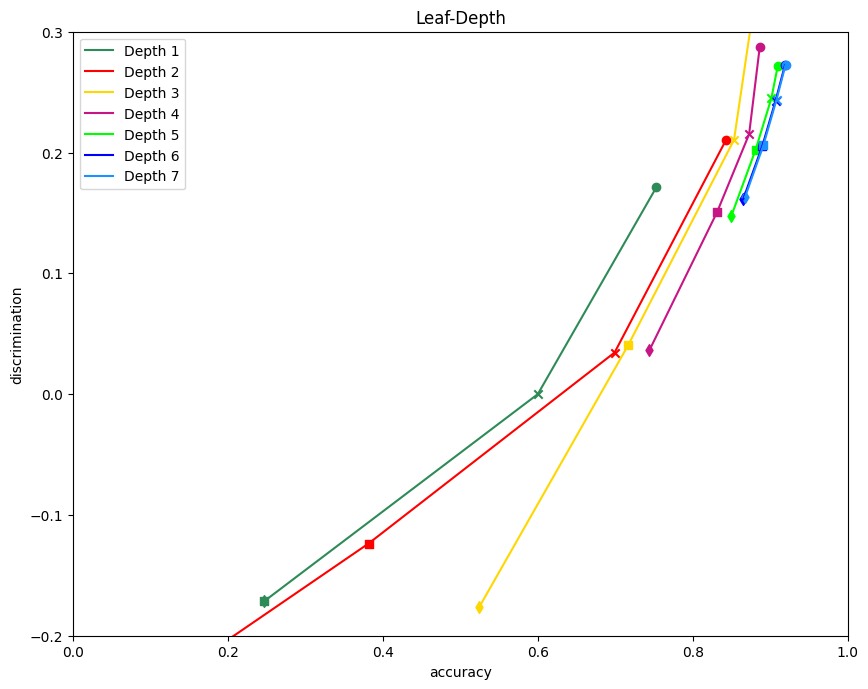

In [ ]:
colors = _COLORS7.copy()
legends = ['Depth 1', 'Depth 2', 'Depth 3', 'Depth 4', 'Depth 5', 'Depth 6', 'Depth 7']
markers = ['o', 'x', 's', 'd', 'p', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']

index_legend = 0
index_color = 0


fig, axes = plt.subplots()
k=0
for depth in df['depth'].unique():
    y_values = list()
    x_values = list()
    index_marker = 0
    for x_axe, y_axe in [('accuracy_pred', 'discrimination_train_pred'), ('accuracy_relab_1', 'discrimination_relab_1'), ('accuracy_relab_2', 'discrimination_relab_2'), ('accuracy_relab_3', 'discrimination_relab_3')]:

        tmp = df.loc[(df["k"] == k) & (df["depth"] == depth)]
        x_values.append(tmp[x_axe].mean())
        y_values.append(tmp[y_axe].mean())

        plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors[index_color], marker=markers[index_marker])
        index_marker +=1

    plt.plot(x_values, y_values, label=legends[index_legend], c=colors[index_color])
    index_color +=1
    index_legend +=1

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title(f'Leaf-Depth')
plt.ylabel('discrimination')
plt.xlabel('accuracy')
plt.ylim(-0.2, 0.3)
plt.xlim(0, 1)
plt.legend()

plt.show()

## Train: Accuracy/Discimination (Threshold)

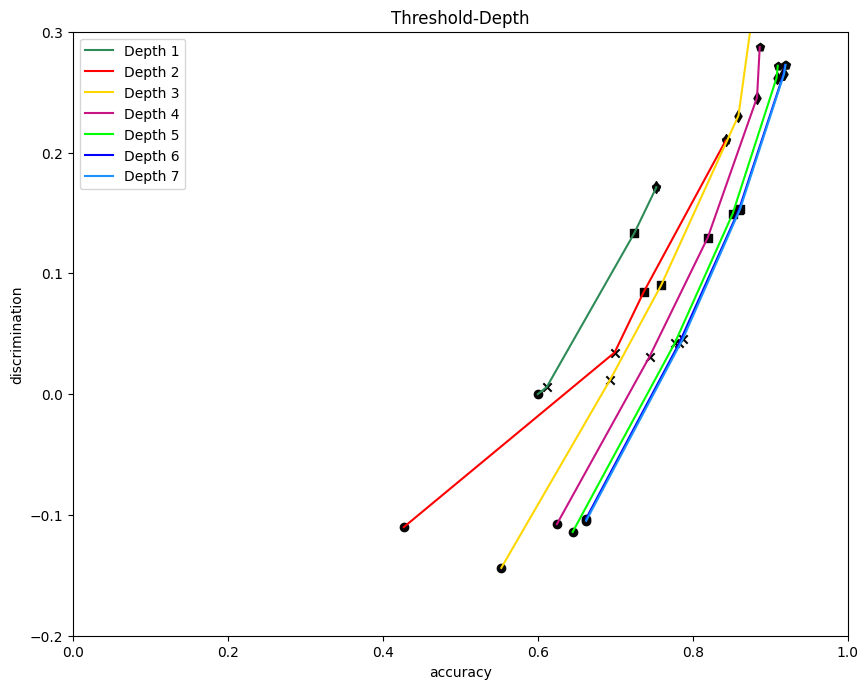

In [ ]:
colors = _COLORS7.copy()
legends = ['Depth 1', 'Depth 2', 'Depth 3', 'Depth 4', 'Depth 5', 'Depth 6', 'Depth 7']
markers = ['o', 'x', 's', 'd', 'p', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']

index_legend = 0
index_color = 0


fig, axes = plt.subplots()
k=0
for depth in df['depth'].unique():
    y_values = list()
    x_values = list()
    index_marker = 0
    for x_axe, y_axe in [('accuracy_relab_0.0', 'discrimination_relab_0.0'), ('accuracy_relab_0.05', 'discrimination_relab_0.05'), 
                         ('accuracy_relab_0.1', 'discrimination_relab_0.1'), ('accuracy_relab_0.15', 'discrimination_relab_0.15'), 
                         ('accuracy_relab_0.2', 'discrimination_relab_0.2'), ('accuracy_relab_0.25', 'discrimination_relab_0.25'), 
                         ('accuracy_relab_0.3', 'discrimination_relab_0.3'), 
                         ('accuracy_pred', 'discrimination_train_pred')]:

        tmp = df.loc[(df["k"] == k) & (df["depth"] == depth)]
        x_values.append(tmp[x_axe].mean())
        y_values.append(tmp[y_axe].mean())

        #plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors[index_color], marker=markers[index_marker])
        plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c='#060606', marker=markers[index_marker])
        index_marker +=1

    plt.plot(x_values, y_values, label=legends[index_legend], c=colors[index_color])
    index_color +=1
    index_legend +=1

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title(f'Threshold-Depth')
plt.ylabel('discrimination')
plt.xlabel('accuracy')
plt.ylim(-0.2, 0.3)
plt.xlim(0, 1)
plt.legend()

plt.show()

In [ ]:
pydl = pandas.read_csv('save/'+"lawsuit_k_supp2_relab"+'.csv')

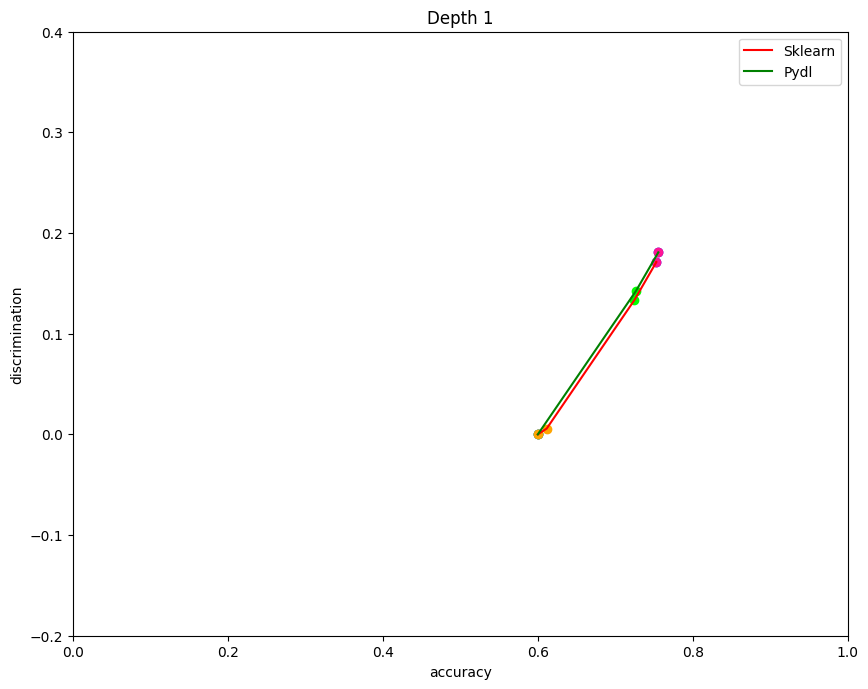

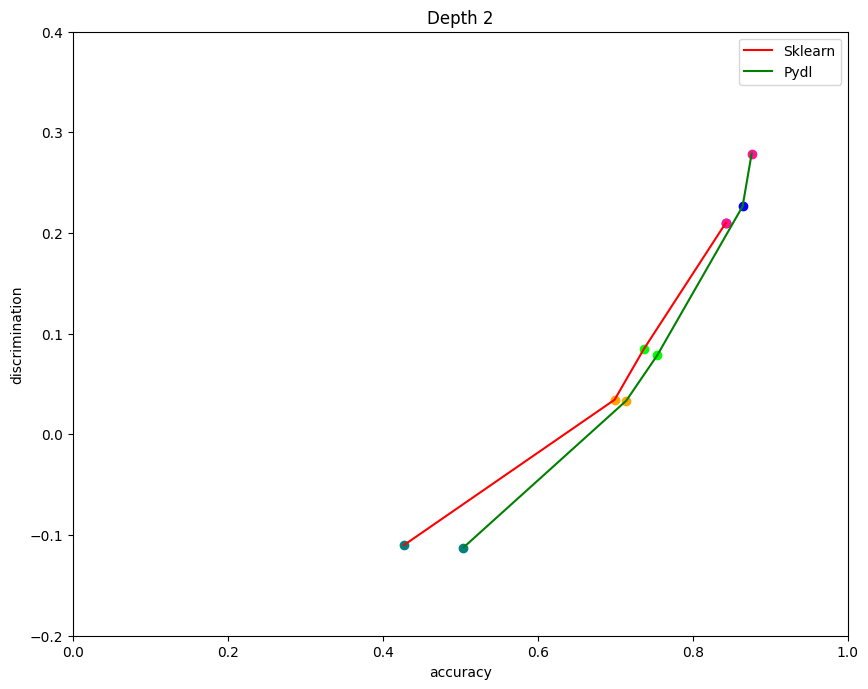

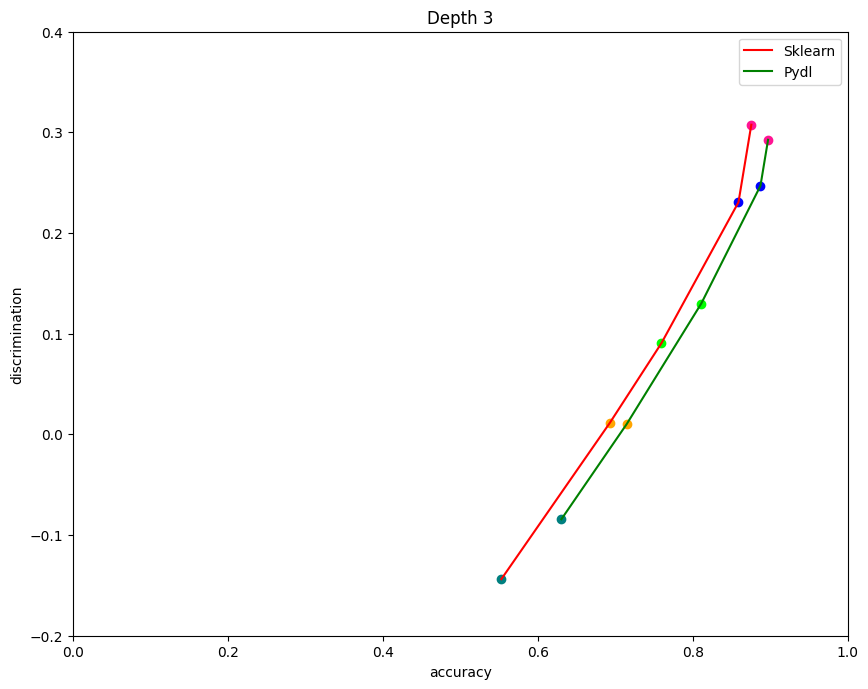

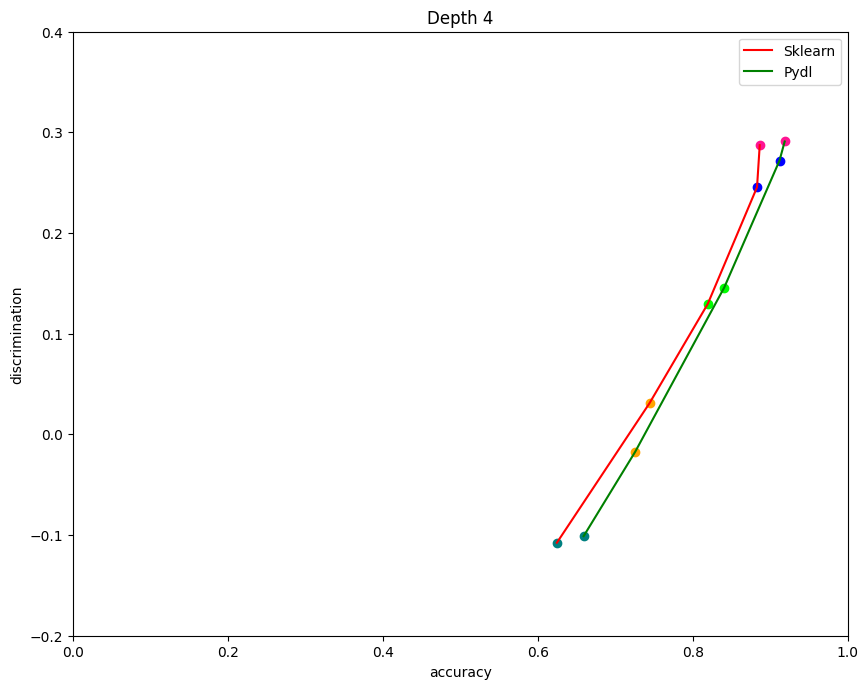

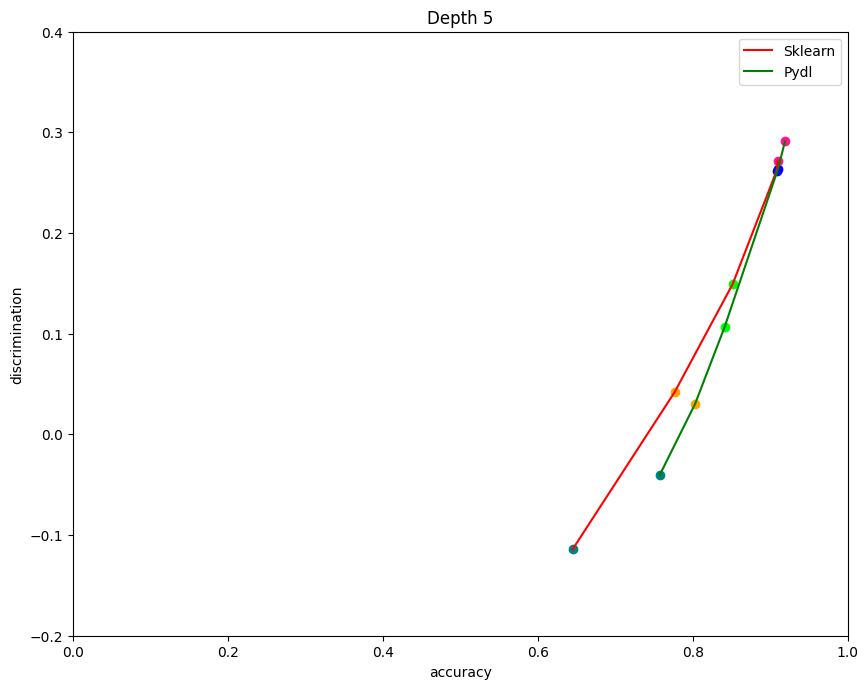

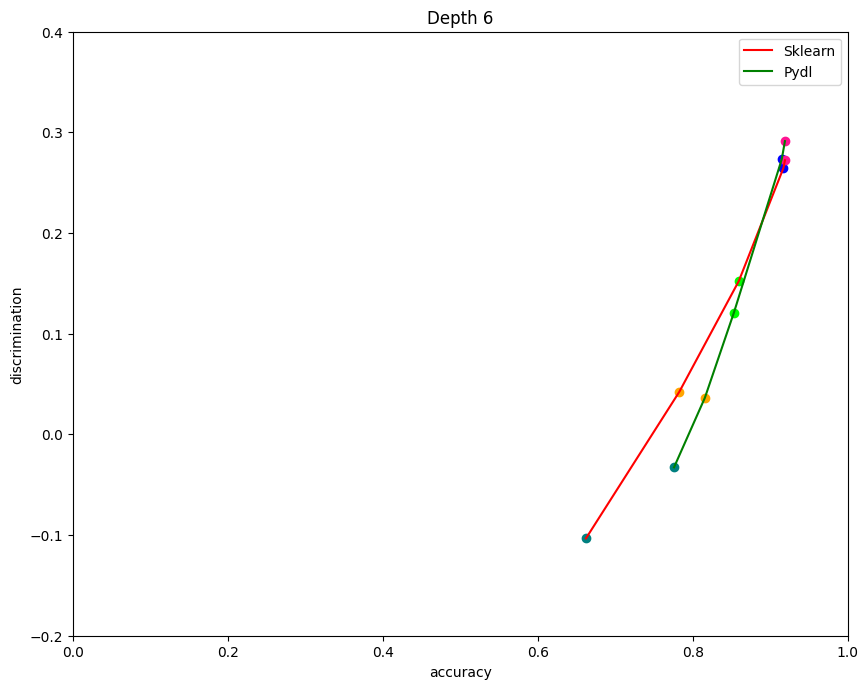

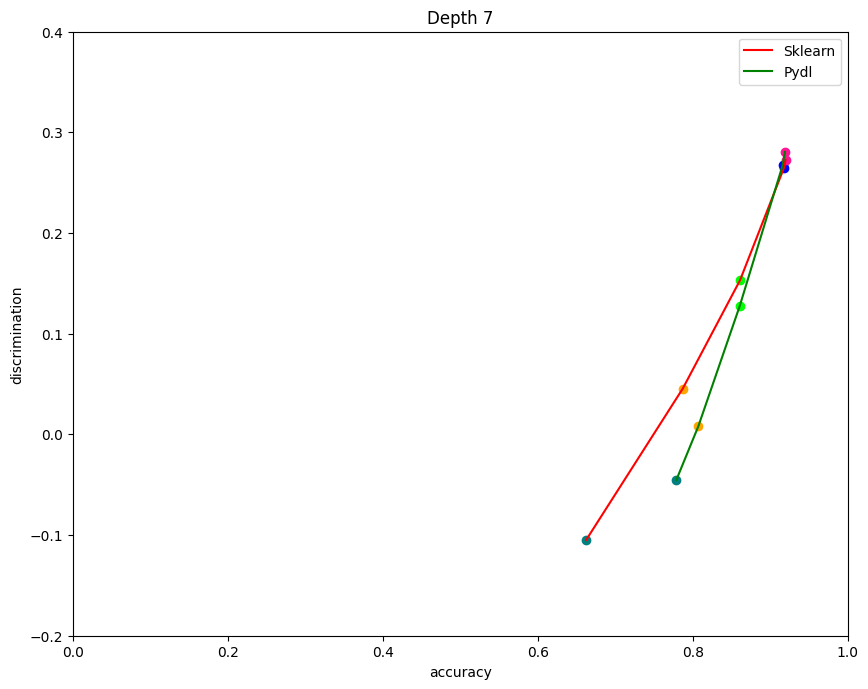

In [ ]:
colors11 = _COLORS11.copy()
colors4 = _COLORS5.copy()
legends = ['relab discrim < 0', 'relab discrim < 0.1', 'relab discrim < 0.2', 'relab discrim < 0.3', 'no relab']
fig, axes = plt.subplots()
for depth in df['depth'].unique():
    index_legends = 0
    y_values = list()
    x_values = list()
    y_values_pydl = list()
    x_values_pydl = list()
    for x_axe, y_axe in [('accuracy_relab_0.0', 'discrimination_relab_0.0'), ('accuracy_relab_0.05', 'discrimination_relab_0.05'),
                         ('accuracy_relab_0.1', 'discrimination_relab_0.1'), ('accuracy_relab_0.15', 'discrimination_relab_0.15'), 
                         ('accuracy_relab_0.2', 'discrimination_relab_0.2'), ('accuracy_relab_0.25', 'discrimination_relab_0.25'), 
                         ('accuracy_relab_0.3', 'discrimination_relab_0.3'),
                         ('accuracy_pred', 'discrimination_train_pred')]:
        index_color = 0
        for k in df['k'].unique():
            tmp = df.loc[(df["k"] == k) & (df["depth"] == depth)]
            x_values.append(tmp[x_axe].mean())
            y_values.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors4[index_legends])

            tmp = pydl.loc[(pydl["k"] == k) & (pydl["depth"] == depth)]
            x_values_pydl.append(tmp[x_axe].mean())
            y_values_pydl.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors4[index_legends])

            index_color +=1
        index_legends +=1
    plt.plot(x_values, y_values, label="Sklearn", c="red")
    plt.plot(x_values_pydl, y_values_pydl, label="Pydl", c="green")

    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('discrimination')
    plt.xlabel('accuracy')
    plt.ylim(-0.2, 0.4)
    plt.xlim(0, 1)
    plt.legend()

    plt.show()

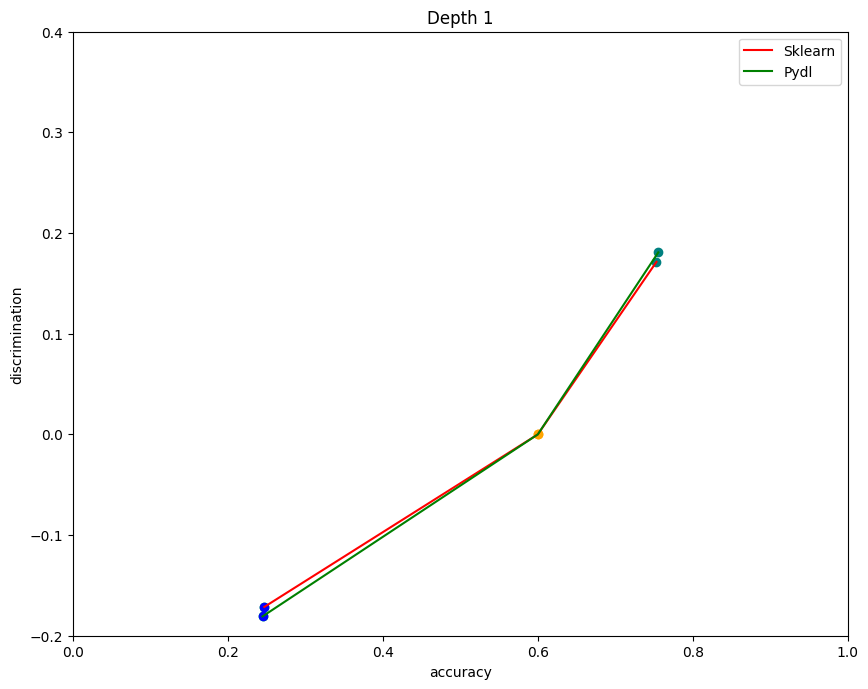

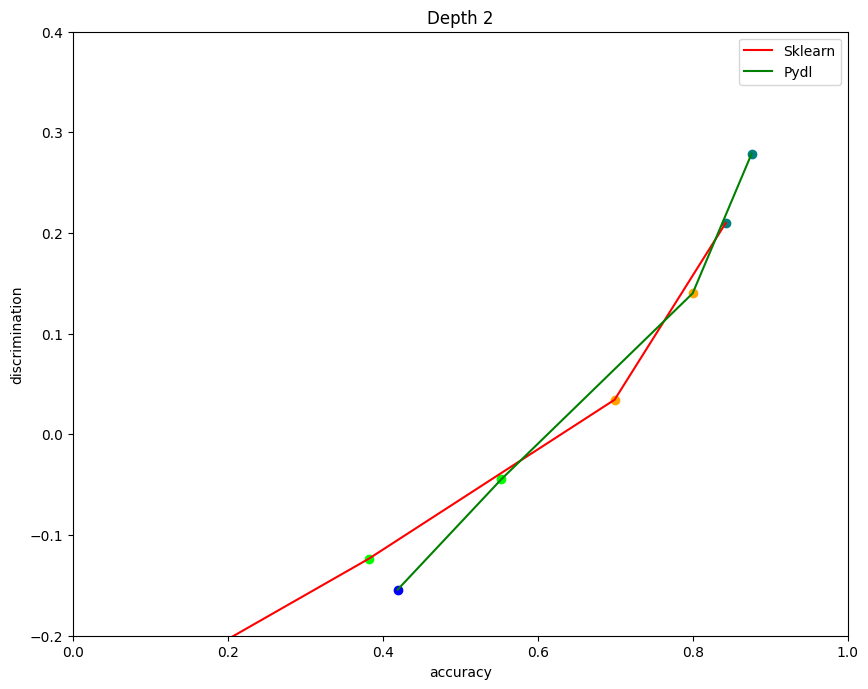

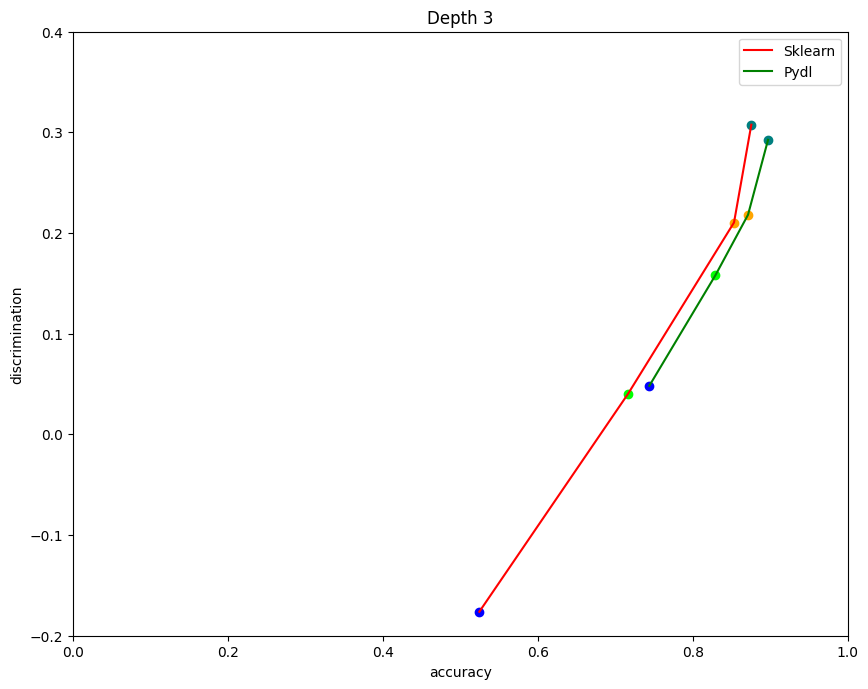

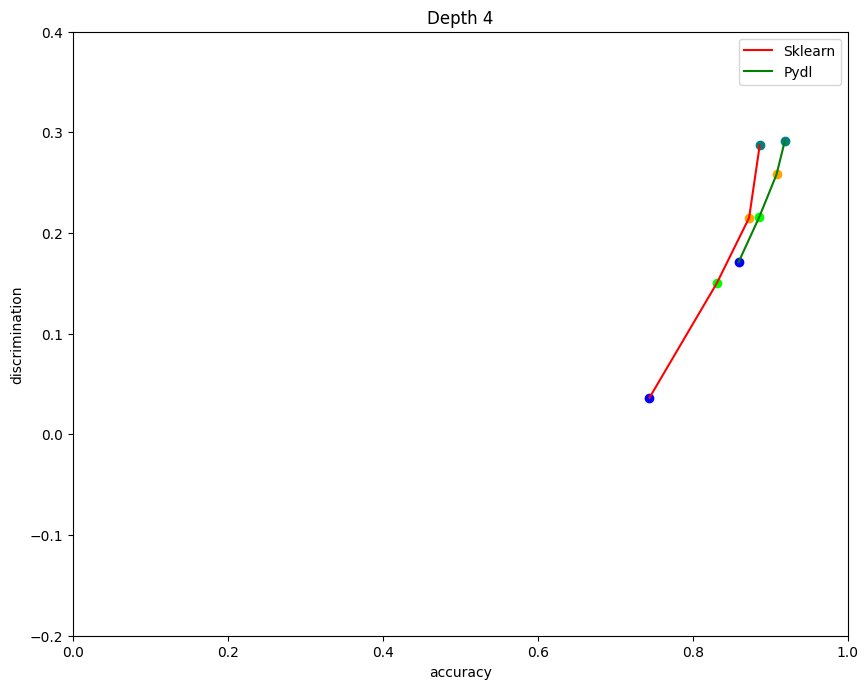

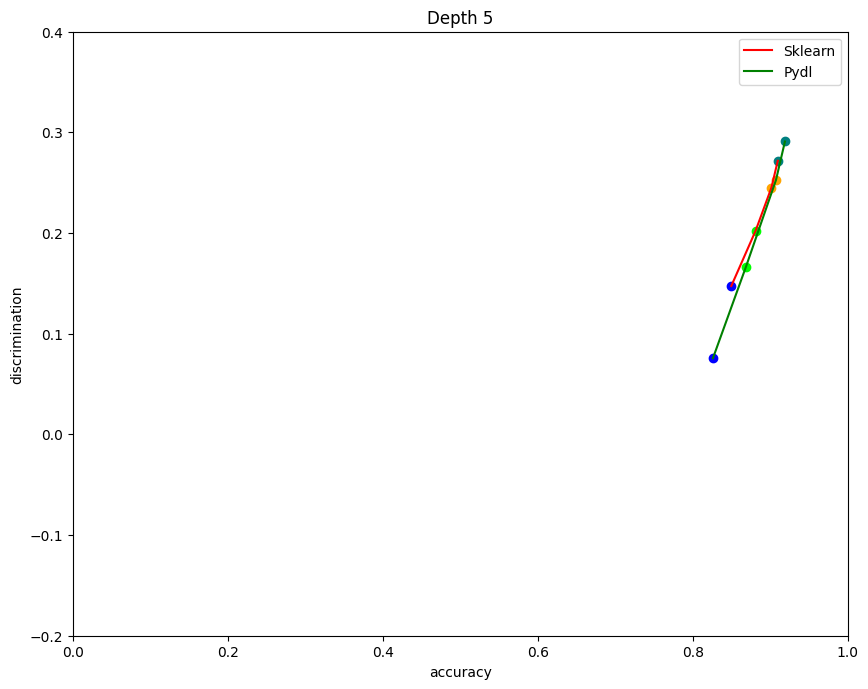

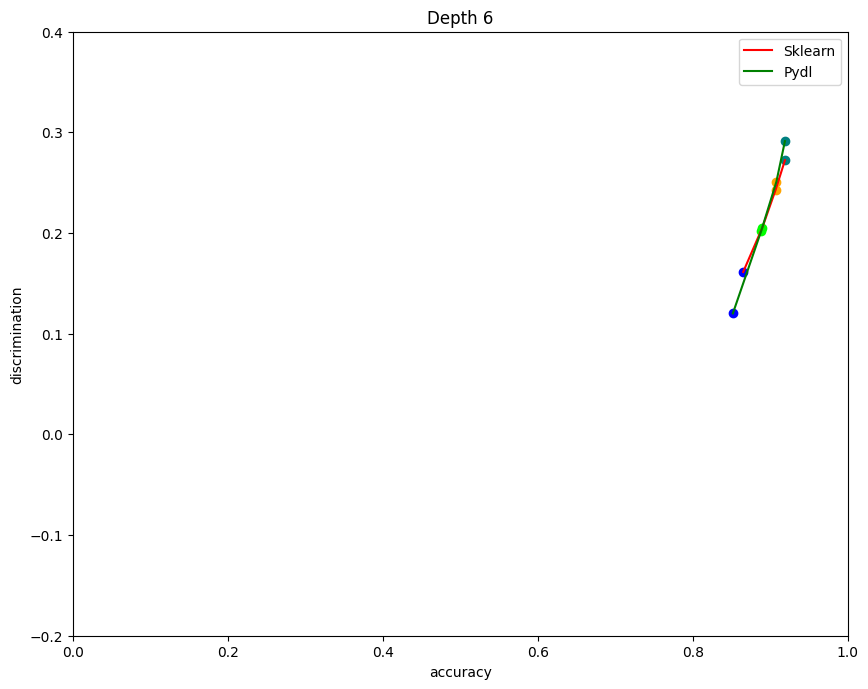

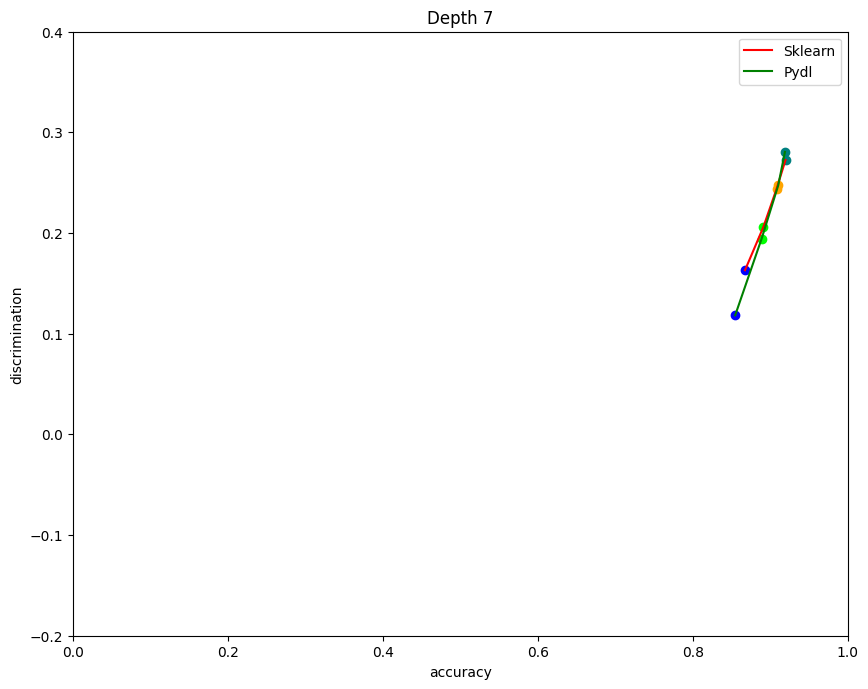

In [ ]:
colors11 = _COLORS11.copy()
colors4 = _COLORS5.copy()
legends = ['relab discrim < 0', 'relab discrim < 0.1', 'relab discrim < 0.2', 'relab discrim < 0.3', 'no relab']
fig, axes = plt.subplots()
for depth in df['depth'].unique():
    index_legends = 0
    y_values = list()
    x_values = list()
    y_values_pydl = list()
    x_values_pydl = list()
    for x_axe, y_axe in [('accuracy_pred', 'discrimination_train_pred'), ('accuracy_relab_1', 'discrimination_relab_1'), ('accuracy_relab_2', 'discrimination_relab_2'), ('accuracy_relab_3', 'discrimination_relab_3')]:
        index_color = 0
        for k in df['k'].unique():
            tmp = df.loc[(df["k"] == k) & (df["depth"] == depth)]
            x_values.append(tmp[x_axe].mean())
            y_values.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors4[index_legends])

            tmp = pydl.loc[(pydl["k"] == k) & (pydl["depth"] == depth)]
            x_values_pydl.append(tmp[x_axe].mean())
            y_values_pydl.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors4[index_legends])

            index_color +=1
        index_legends +=1
    plt.plot(x_values, y_values, label="Sklearn", c="red")
    plt.plot(x_values_pydl, y_values_pydl, label="Pydl", c="green")

    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('discrimination')
    plt.xlabel('accuracy')
    plt.ylim(-0.2, 0.4)
    plt.xlim(0, 1)
    plt.legend()

    plt.show()

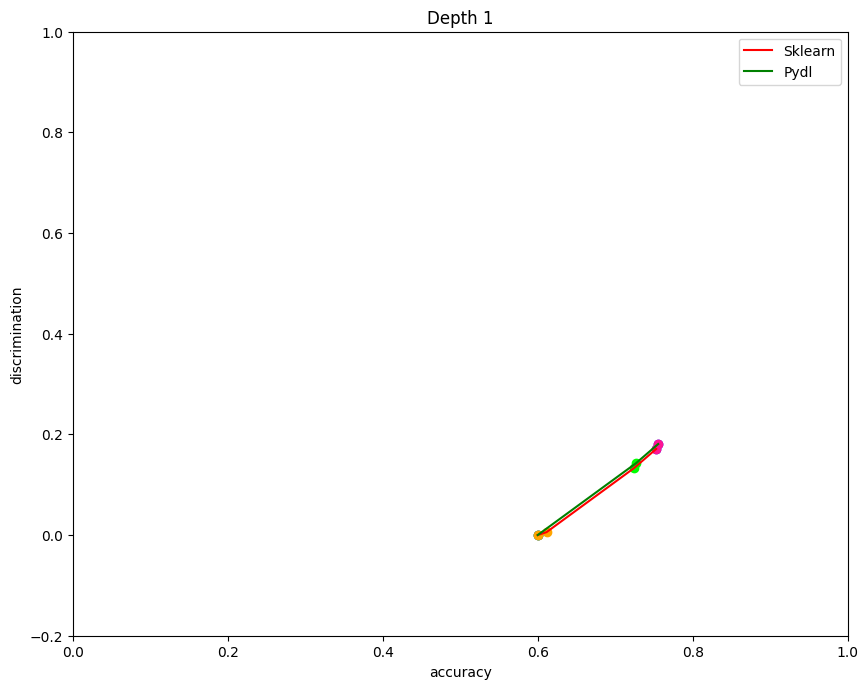

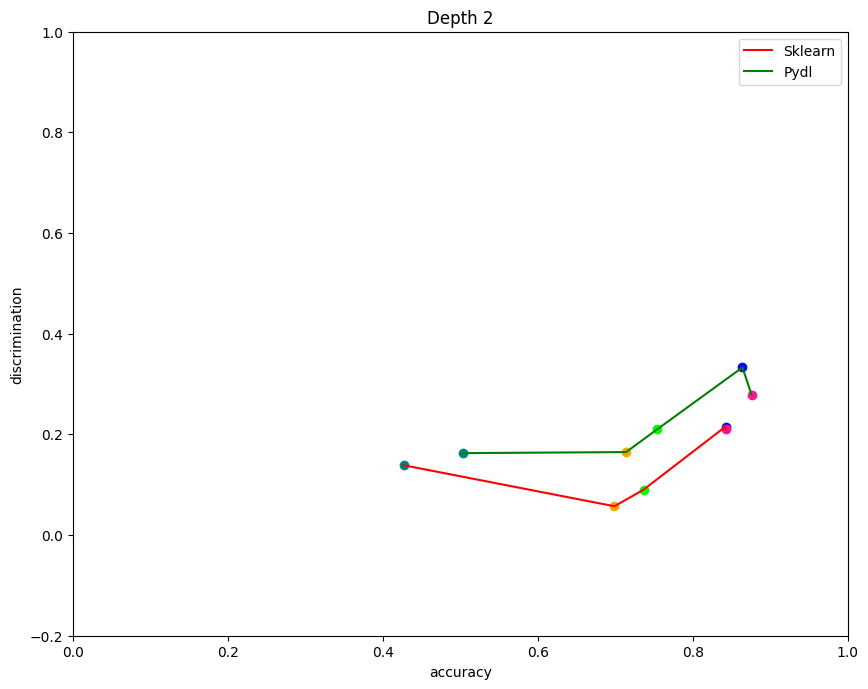

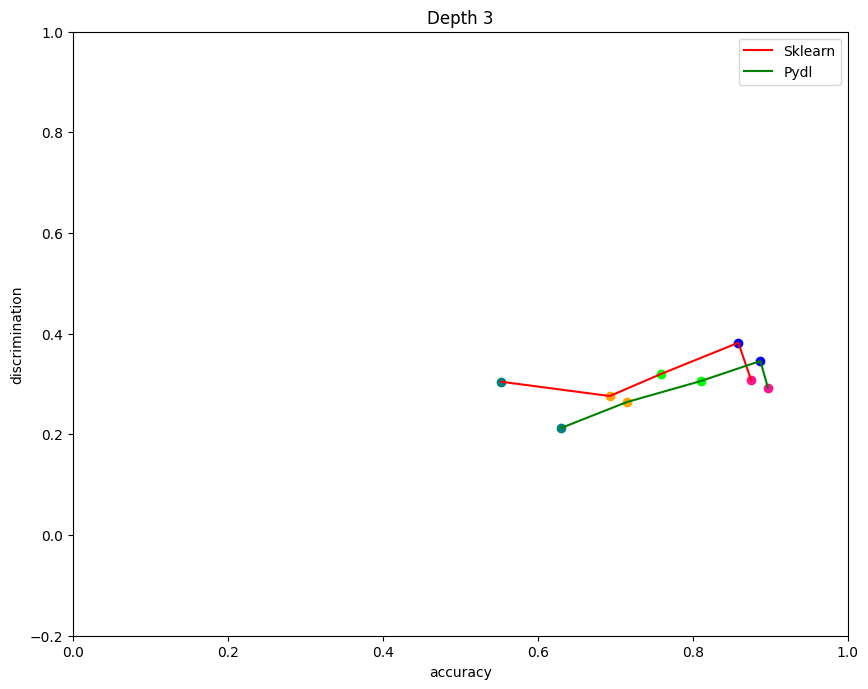

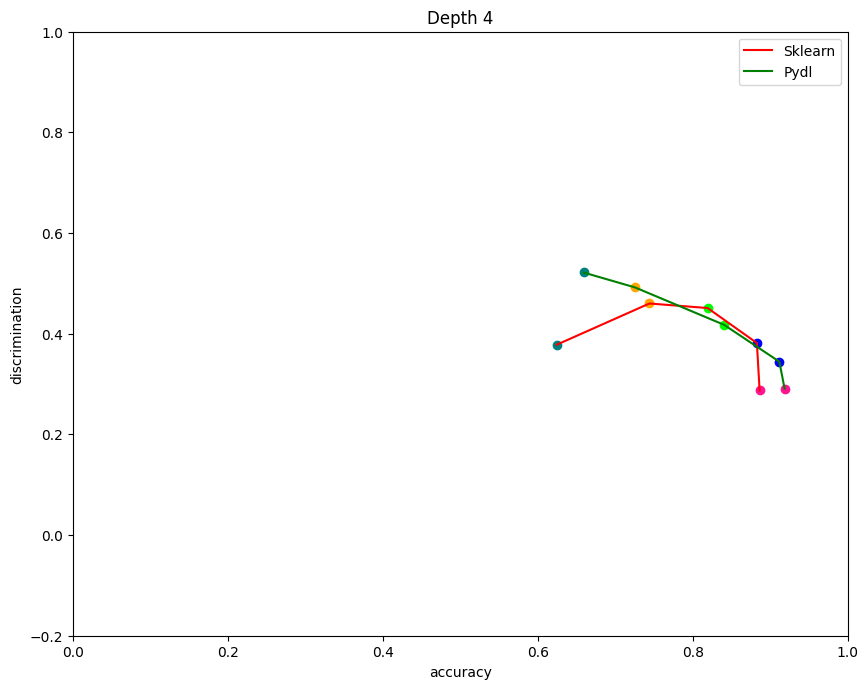

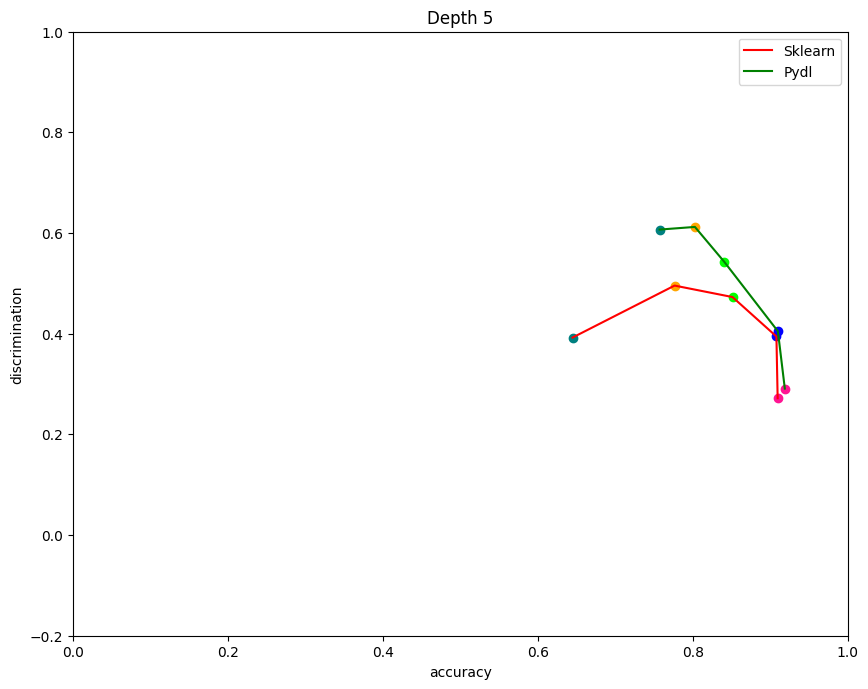

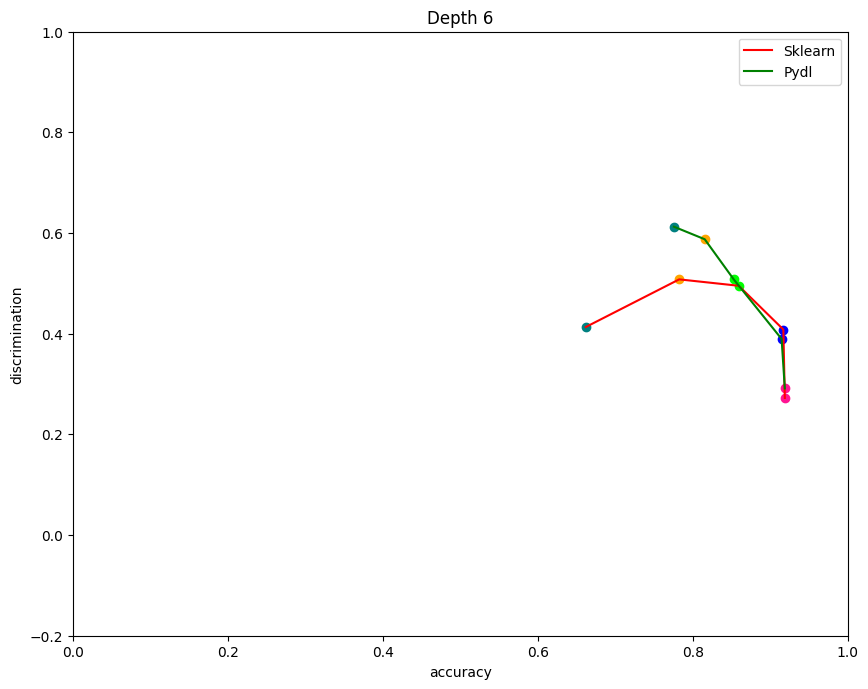

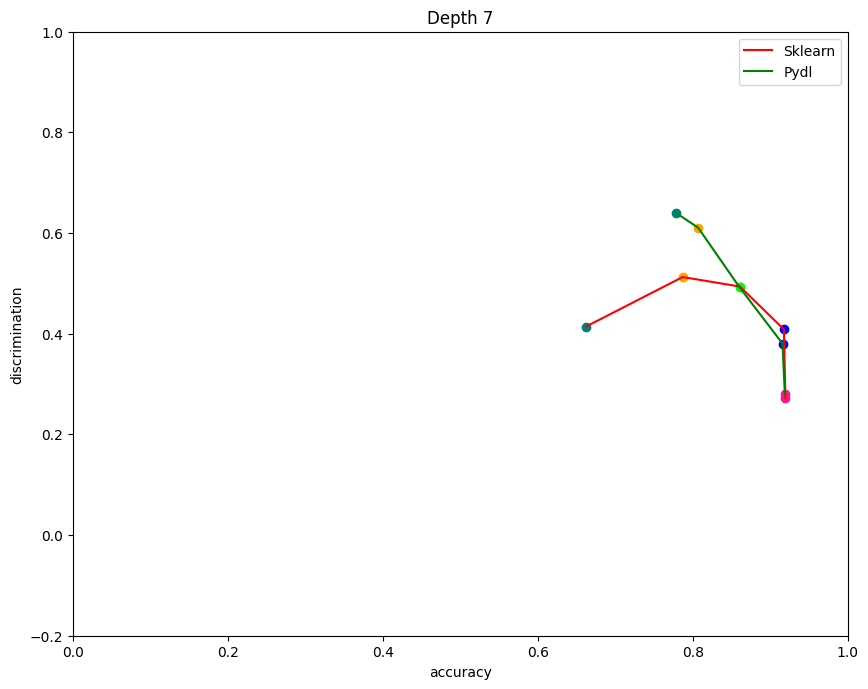

In [ ]:
colors11 = _COLORS11.copy()
colors4 = _COLORS5.copy()
legends = ['relab discrim < 0', 'relab discrim < 0.1', 'relab discrim < 0.2', 'relab discrim < 0.3', 'no relab']
fig, axes = plt.subplots()
for depth in df['depth'].unique():
    index_legends = 0
    y_values = list()
    x_values = list()
    y_values_pydl = list()
    x_values_pydl = list()
    for x_axe, y_axe in [('accuracy_relab_0.0', 'discrimination_relab_abs_0.0'), ('accuracy_relab_0.1', 'discrimination_relab_abs_0.1'), ('accuracy_relab_0.2', 'discrimination_relab_abs_0.2'), ('accuracy_relab_0.3', 'discrimination_relab_abs_0.3'), ('accuracy_pred', 'discrimination_train_pred')]:
        index_color = 0
        for k in df['k'].unique():
            tmp = df.loc[(df["k"] == k) & (df["depth"] == depth)]
            x_values.append(tmp[x_axe].mean())
            y_values.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors4[index_legends])

            tmp = pydl.loc[(pydl["k"] == k) & (pydl["depth"] == depth)]
            x_values_pydl.append(tmp[x_axe].mean())
            y_values_pydl.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors4[index_legends])

            index_color +=1
        index_legends +=1
    plt.plot(x_values, y_values, label="Sklearn", c="red")
    plt.plot(x_values_pydl, y_values_pydl, label="Pydl", c="green")

    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('discrimination')
    plt.xlabel('accuracy')
    plt.ylim(-0.2, 1)
    plt.xlim(0, 1)
    plt.legend()

    plt.show()